In [2]:
train_model = True  # Set true if you want to train the model

In [3]:
# Remove here everything unnecessary

import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import date
from scipy.integrate import solve_ivp
from scipy import integrate, optimize
import numpy as np

%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano


/home/tommi/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# Some country codes

###############################
#country_name = "Germany"
#countrycode = "Q83889294"
#population = 83000000
#school_closure = date(2020, 3, 13) 

###############################
country_name = "Italy"
countrycode = "Q84104992"
population = 60360000
school_closure = date(2020, 3, 4) 

###############################
#country_name = "Norway"
#countrycode = "Q86886544"
#population = 5370000
#school_closure = date(2020, 3, 12) 

In [5]:
# Timeperiods defined

# Define the lengths of different timeperiods: period 1 = time before school closure, 
# period 2 = len_timeperiod2 amount of time after the school closure , ...
len_timeperiod1 = 14
len_timeperiod2 = 14
len_timeperiod3 = 14

In [6]:
url = 'https://query.wikidata.org/sparql'
query = """
SELECT
  ?nrcases ?timepoint
WHERE {
 wd:%s p:P1603 ?p .
  ?p pq:P585 ?timepoint ;
     ps:P1603 ?nrcases .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
""" % (countrycode)

r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
data = r.json()

cases = []
#cleans the data because some values are missing
for item in data['results']['bindings']:
    cases.append(OrderedDict({'time': item['timepoint']['value'],
'nrcases': item['nrcases']['value']
}))
    
df_wikidata=pd.DataFrame(cases)
print(df_wikidata['time'].values)

['2020-01-31T00:00:00Z' '2020-02-01T00:00:00Z' '2020-02-02T00:00:00Z'
 '2020-02-03T00:00:00Z' '2020-02-04T00:00:00Z' '2020-02-05T00:00:00Z'
 '2020-02-07T00:00:00Z' '2020-02-22T00:00:00Z' '2020-02-22T00:00:00Z'
 '2020-02-23T00:00:00Z' '2020-02-24T00:00:00Z' '2020-02-28T00:00:00Z'
 '2020-03-15T00:00:00Z' '2020-03-16T00:00:00Z' '2020-03-18T00:00:00Z'
 '2020-03-17T00:00:00Z' '2020-03-19T00:00:00Z' '2020-03-14T00:00:00Z'
 '2020-03-13T00:00:00Z' '2020-03-12T00:00:00Z' '2020-03-11T00:00:00Z'
 '2020-03-10T00:00:00Z' '2020-03-08T00:00:00Z' '2020-03-09T00:00:00Z'
 '2020-03-07T00:00:00Z' '2020-03-06T00:00:00Z' '2020-03-05T00:00:00Z'
 '2020-02-28T00:00:00Z' '2020-03-20T00:00:00Z' '2020-03-21T00:00:00Z'
 '2020-03-22T00:00:00Z' '2020-03-23T00:00:00Z' '2020-03-24T00:00:00Z'
 '2020-03-26T00:00:00Z' '2020-03-27T00:00:00Z' '2020-03-28T00:00:00Z'
 '2020-03-29T00:00:00Z' '2020-03-30T00:00:00Z' '2020-03-31T00:00:00Z'
 '2020-04-01T00:00:00Z' '2020-04-02T00:00:00Z' '2020-04-03T00:00:00Z'
 '2020-04-04T00:00:0

In [7]:
import datetime

dates = df_wikidata['time'].values
cases = df_wikidata['nrcases'].values

for ind in list(range(len(cases))): 
    cases[ind] = int(cases[ind])
    dates[ind] = datetime.datetime.strptime(dates[ind],"%Y-%m-%dT%H:%M:%SZ")


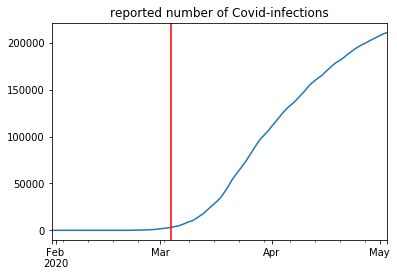

In [8]:
zipped_list = list(zip(dates, cases))
zipped_list.sort(key=lambda tup: tup[0])

dates = []
cases = []
for i in zipped_list:
   dates.append(i[0])
   cases.append(i[1])
    
ts = pd.Series(cases,dates)
ts = ts.resample('D').mean()
ts = ts.interpolate()
ts = ts.astype('int64')

ts.plot(title="reported number of Covid-infections")
plt.axvline(school_closure, color='r')

In [9]:
# Find the correct index for school closure
shutdown_ind = 0
for i in range(len(ts.values)):
    if ts.index[i] == school_closure:
        shutdown_ind = i
                
# obs_cum are the cumulative cases 
obs_cum = ts.values[shutdown_ind - len_timeperiod1: shutdown_ind + len_timeperiod2 + len_timeperiod3]

# obs_new is a list of daily new cases 
obs_new = obs_cum.copy()
ind = len(obs_new) - 1
while ind >= 1:
    obs_new[ind] = obs_cum[ind] - obs_cum[ind-1]
    ind = ind - 1
obs_new[0] = obs_cum[0] - ts.values[shutdown_ind - len_timeperiod1 -1]


len_total_timeline = len_timeperiod1 + len_timeperiod2 + len_timeperiod2
times = np.arange(len_total_timeline)
timeline1 = np.arange(len_timeperiod1)
timeline2 = np.arange(len_timeperiod1, len_timeperiod1 + len_timeperiod2)
timeline3 = np.arange(len_timeperiod1 + len_timeperiod2, len_total_timeline)

N = population 

# Initial stages
exp0 = obs_cum[6] - obs_cum[1]
inf0 = obs_cum[0]
asy0 = obs_cum[0]
sus0 = N - exp0 - inf0 -asy0
hos0 = 0

In [12]:
# Parameters of the model
alpha = 1
D_e = 5.2
D_i = 2.3
D_q = 7
D_h = 30

In [11]:
# SEIR-model itself

# y[0]: S, y[1]: E, y[2]: I, y[3]: A, y[4]: H, y[5]: R
# p[0]: beta_i, p[1]: r_i
def SEIR(y, t, p):
    ds = -p[0] * y[0] * (y[2] + alpha * y[3]) / N
    de =  p[0] * y[0] * (y[2] + alpha * y[3]) / N - y[1] / D_e
    di =  p[1] * y[1] / D_e - y[2] / D_q - y[2] / D_i
    da =  (1 - p[1]) * y[1] / D_e - y[3] / D_i
    dh =  y[2] / D_q - y[4] / D_h
    return [ds, de, di, da, dh]  

In [12]:
# There is one seir_model for each timeline

seir_model1 = DifferentialEquation(
    func=SEIR,
    times=timeline1,
    n_states=5, # S, E, I, A, H. (no need to have R)
    n_theta=2,
    t0=0,
)

seir_model2 = DifferentialEquation(
    func=SEIR,
    times=timeline2,
    n_states=5,
    n_theta=2,
    t0=len_timeperiod1,
)

In [13]:
with pm.Model() as modelSIR:
    
    # R0 can be checked out later...
    beta1 =  pm.Uniform('beta1', 0.2, 5)
    beta2 =  pm.Uniform('beta2', 0.2, 5)
    r1 =  pm.Uniform('r1', 0, 1)
    r2 =  pm.Uniform('r2', 0, 1)
    
    seir_curves1 = seir_model1(y0 = [sus0, exp0, inf0, asy0, hos0], theta=[beta1,r1,])
    seir_curves2 = seir_model2(y0 = [seir_curves1[-1 ,0], seir_curves1[-1 ,1], seir_curves1[-1 ,2],
    seir_curves1[-1 ,3], seir_curves1[-1 ,4],], theta=[beta2,r2,])
    lambda_ = theano.tensor.concatenate([seir_curves1[: ,1] * r1, seir_curves2[:,1] * r2]) / D_e
        
    new_infectious = pm.Poisson('new_infectious', lambda_ , observed = obs_new[0:len_timeperiod1 + len_timeperiod2])

In [14]:
if train_model:
    with modelSIR:
        trace = pm.sample(500,tune=500, target_accept = 0.95, cores=1)
        db = pm.backends.Text('italy_seiahr_2tls_50_50')
        pm.save_trace(trace, directory = 'italy_seiahr_2tls_50_50', overwrite=True)
else:
    with modelSIR:
        trace = pm.load_trace(directory = 'italy_seiahr_2tls_50_50')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [r2, r1, beta2, beta1]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [33:00:27<00:00, 118.83s/it]   
The estimated number of effective samples is smaller than 200 for some parameters.


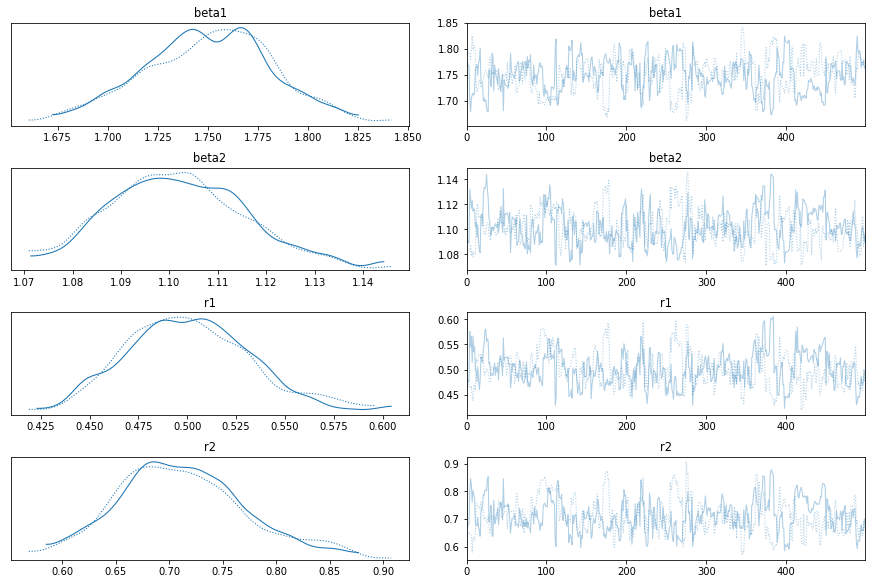

In [15]:
pm.traceplot(trace);

In [10]:
beta1_estimated = np.mean(trace.beta1)
beta2_estimated = np.mean(trace.beta2)
r1_estimated = np.mean(trace.r1)
r2_estimated = np.mean(trace.r2)

In [13]:
# This cell defines a slightly modified SEIR-model that will also count the cumulative number of infected 
# by adding one extra state. The old SEIR-model(s) won't work because in there infected will get healthy
# and not remain always infected

extended_timeline2 = np.arange(1 + len_timeperiod2 + len_timeperiod3)
total_timeline = np.arange(len_timeperiod1 + len_timeperiod2 + len_timeperiod3)

def SEIR_cum(y, t, p):
    ds = -p[0] * y[0] * (y[2] + alpha * y[3]) / N
    de =  p[0] * y[0] * (y[2] + alpha * y[3]) / N - y[1] / D_e
    di =  p[1] * y[1] / D_e - y[2] / D_q - y[2] / D_i
    da =  (1 - p[1]) * y[1] / D_e - y[3] / D_i
    dh =  y[2] / D_q - y[4] / D_h
    
    dcum_i = p[1] * y[1] / D_e  # cumulative number of infected
    
    return [ds, de, di, da, dh, dcum_i]  



# Solve the first timeline
dcum_i_0 = 0 # set counter to 0

y1 = odeint(SEIR_cum, t=timeline1, y0=[sus0, exp0, inf0, asy0, hos0, dcum_i_0],
           args=((beta1_estimated ,r1_estimated,),), rtol=1e-8)

sus1 = y1[-1,0] # sus0 was the initial value for first time line, sus1 for the seceond
exp1 = y1[-1,1]
inf1 = y1[-1,2]
asy1 = y1[-1,3]
hos1 = y1[-1,4]
rec1 = N - sus1 - exp1 - inf1 - asy1 - hos1
dcum_i_1timeline = y1[:,5]

# Solve the second extended timeline
y2 = odeint(SEIR_cum, t=extended_timeline2, y0=[sus1, exp1, inf1, asy1, hos1, dcum_i_1timeline[-1]],
           args=((beta2_estimated ,r2_estimated,),), rtol=1e-8)

sus2 = y2[-1,0] # sus0 was the initial value for first time line, sus1 for the seceond
exp2 = y2[-1,1]
inf2 = y2[-1,2]
asy2 = y2[-1,3]
hos2 = y2[-1,4]
rec2 = N - sus2 - exp2 - inf2 - asy2 - hos2

dcum_i_2timeline = y2[:,5]

# combine cumulative cases of infected
dcum_combined = np.concatenate((dcum_i_1timeline, dcum_i_2timeline[1:]), axis = 0)

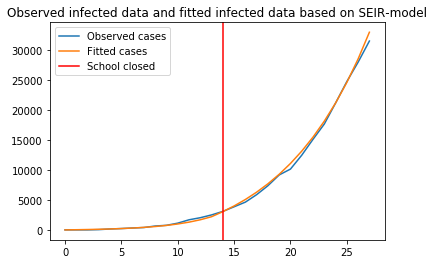

In [14]:
# Plot observed cumulative infected and the amount of newly infected based on SEIR-model

observed_inf = plt.plot(total_timeline[0:len_timeperiod1+len_timeperiod2],
    obs_cum[0:len_timeperiod1+len_timeperiod2], label='Observed cases')


model_inf = plt.plot(total_timeline[0:len_timeperiod1+len_timeperiod2],
    dcum_combined[0:len_timeperiod1+len_timeperiod2], label = "Fitted cases")

school_closed = plt.axvline(len_timeperiod1, color='r', label ="School closed")
plt.title("Observed infected data and fitted infected data based on SEIR-model")
plt.legend(loc="upper left")
plt.show()

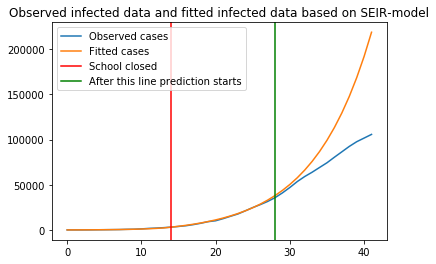

In [15]:
# Plot observed cumulative infected and the amount of newly infected based on SEIR-model

observed_inf = plt.plot(total_timeline, obs_cum, label='Observed cases')

model_inf = plt.plot(total_timeline, dcum_combined, label = "Fitted cases")

school_closed = plt.axvline(len_timeperiod1, color='r', label ="School closed")
prediction_starts = plt.axvline(len_timeperiod1 + len_timeperiod2, color='g',
                        label ="After this line prediction starts")
plt.title("Observed infected data and fitted infected data based on SEIR-model")
plt.legend(loc="upper left")
plt.show()